In [1]:

import tensorflow as tf
import numpy as np
import pandas as pd
import time
import matplotlib.pylab as plt

C:\Users\User\AppData\Local\conda\conda\envs\tensorflow1\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#  Matrix factorization with Tensorflow framework
## It only use tensorflow framework to accumulate the MF speed

In [35]:
### matrix factorization with Tensorflow

def TensorFlow_MF(R_df,test):
    ## load the movielens data 100k

    A_df_masked= R_df

    # np_mask = A_df_masked.notnull()
    # np_mask

    np_mask = R_df>0

    # Boolean mask for computing cost only on valid (not missing) entries
    tf_mask = tf.Variable(np_mask.values)

    A = tf.constant(A_df_masked.values)
    shape = A_df_masked.values.shape

    #latent factors
    rank = 10 

    start_time = time.time()
    # Initializing random H and W
    temp_H = np.random.randn(rank, shape[1]).astype(np.float64)
    temp_H = np.divide(temp_H, temp_H.max())

    temp_W = np.random.randn(shape[0], rank).astype(np.float64)
    temp_W = np.divide(temp_W, temp_W.max())

    H =  tf.Variable(temp_H)
    W = tf.Variable(temp_W)
    WH = tf.matmul(W, H)

    #cost function 
    #cost of Frobenius norm
    cost = tf.reduce_sum(tf.pow(tf.boolean_mask(A, tf_mask) - tf.boolean_mask(WH, tf_mask), 2))

    # Learning rate
    lr = 0.001
    # Number of steps
    train_step = tf.train.GradientDescentOptimizer(lr).minimize(cost)
    init = tf.global_variables_initializer()

    # Ensure non-negativity
    # Clipping operation. This ensure that W and H learnt are non-negative
    clip_W = W.assign(tf.maximum(tf.zeros_like(W), W))
    clip_H = H.assign(tf.maximum(tf.zeros_like(H), H))
    clip = tf.group(clip_W, clip_H)

    # main tensor flow iteration
    steps = 2000
    with tf.Session() as sess:
        sess.run(init)
        for i in range(steps):
            sess.run(train_step)
            sess.run(clip)
#             if i%100==0:
#                 print("\nCost: %f" % sess.run(cost))
#                 print("*"*40)
        learnt_W = sess.run(W)
        learnt_H = sess.run(H)
    # evaluate
    pred = np.dot(learnt_W, learnt_H)
    pred_df = pd.DataFrame(pred)
    time_duration = time.time()-start_time
    test_mask = test>0
#     pred_df.round()
    RMSE = np.sqrt(np.sum(np.power(pred-test,2)*test_mask)/np.sum(test_mask))
    print(RMSE)
    return RMSE, time_duration
    
#resource:  https://nipunbatra.github.io/blog/2017/nnmf-tensorflow.html

# Regulare Matrix Factorization with gradient descent

In [3]:
## matrix factorization with regular Gradient descent

import numpy as np
import math

def matrix_factorization(R,  K, steps=200,  alpha=0.001, beta=0.02):
    N = len(R)
    M = len(R[0])

    P = np.random.rand(N,K)
    Q = np.random.rand(M,K)
    Q = Q.T
    for step in range(steps):
#         print(step)
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                    for k in range(K):
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                    for k in range(K):
                        e = e + (beta/2) * ( pow(P[i][k],2) + pow(Q[k][j],2) )
#        print e
        if e < 0.001:
            break
    print('+++++++++++Finished+++++++++++')
    return P, Q, e

In [22]:

def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    print(test.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], size=10, replace=False)
        train[user][test_ratings] = 0
        for j in test_ratings:
            test[user][j] = ratings[user][j]
    return train, test

In [23]:
import pandas as pd
# pass in column names for each CSV
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k\\u.user', sep='|', names=u_cols)

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k\\u.data', sep='\t', names=r_cols,encoding='latin-1')

# the movies file contains columns indicating the movie's genres
# let's only load the first five columns of the file with usecols
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv('ml-100k\\u.item', sep='|', names=m_cols, usecols=range(5),encoding='latin-1')

# create one merged DataFrame
movie_ratings = pd.merge(movies, ratings)
lens = pd.merge(movie_ratings, users)

Ratings = movie_ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)


R_df, test = train_test_split(Ratings.values)

(943, 1682)


In [31]:
### regular matrix factorization without deep learning framework
start_time = time.time()
p,q, error = matrix_factorization(R_df,10)
pred = np.dot(p,q)
end_time = time.time()
test_mask = test>0
RMSE = np.sqrt(np.sum(np.power(pred-test,2)*test_mask)/np.sum(test_mask))
print('--- RMSE %s---' % (RMSE))
print("--- %s seconds ---" % (end_time - start_time))

--- RMSE 0.7992821849915749---
--- 1056.0881378650665 seconds ---


In [36]:
### matrix factorization with tensor flow with CF
R_df1 = pd.DataFrame(R_df,test)
rmse_1, dur_time = TensorFlow_MF(R_df1,test)
print("--- %s seconds ---" %  (dur_time))

print('---RMSE %s---' % (rmse_1))

1.5358301504373773
--- 39.80103898048401 seconds ---
---RMSE 1.5358301504373773---


# Matrix factorization with tensorflow framework
## it first applies user embedding and item embedding
## It use neural network to train

C:\Users\User\AppData\Local\conda\conda\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:24: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\User\AppData\Local\conda\conda\envs\tensorflow1\lib\site-packages\keras\legacy\layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


--- 193.3180012702942 seconds ---
---RMSE 1.1092790451459902---


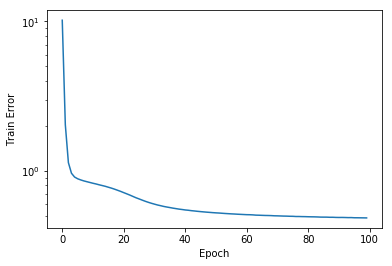

In [37]:
## Matrix factorization with user embedding and item embedding

dataset = pd.read_csv("ml-100k\\u.data",sep='\t',names="user_id,item_id,rating,timestamp".split(","))
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2)

import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt

n_users, n_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())
n_latent_factors = 10
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))

prod = keras.layers.merge([movie_vec, user_vec], mode='dot',name='DotProduct')
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

start_time = time.time()
history = model.fit([train.user_id, train.item_id], train.rating, epochs=100, verbose=0)

end_time = time.time()
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
y_hat = np.round(model.predict([test.user_id, test.item_id]),0)

dur_time = end_time-start_time
y_true = test.rating
print("--- %s seconds ---" %  (dur_time))
from sklearn.metrics import mean_squared_error

RMSE2=mean_squared_error(y_true, y_hat)
print('---RMSE %s---' %(np.sqrt(RMSE2)))

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 10)        16830       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 10)        9440        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

# conclusion

# We can see here that regular give a good RMSE, but it takes much longer
# We can see the TensorFlow framework does not help the MF a lot. It takes less time but RMSE is not good
# The Matrix factorization with users embedding and item embedding has decent RMSE as well as running time